**Lindbald Master Equation and Hamiltonian**

---

$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}[2\sigma_{1}\rho\sigma_{1}^{\dagger}-\sigma_{1}^{\dagger}\sigma_{1}\rho-\rho\sigma_{1}^{\dagger}\sigma_{1}] $$

$$ H_{1}=[\omega_{0}+A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1}-\frac{i\Omega_{R}}{2}(e^{-i\varepsilon t}\sigma_{1}^{\dagger}-H.c) $$

Master Equation and Hamiltonian (N=2)

---
$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}\sum^{2}_{j,k=1}cos[q(z_{j}-z_{k})][2\sigma_{j}\rho\sigma_{k}^{\dagger}-\sigma_{k}^{\dagger}\sigma_{j}\rho-\rho\sigma_{k}^{\dagger}\sigma_{j}] $$

$$ H_{1}=\sum^{2}_{j=1}[\omega_{0}+A_{j}(t)]\sigma_{j}^{\dagger}\sigma_{j}+\gamma_{1D}sin[q(z_{1}-z_{2})](\sigma_{1}^{\dagger}\sigma_{2}-\sigma_{2}^{\dagger}\sigma_{1})-\frac{i\Omega_{R}}{2}\sum^{2}_{j=1}(e^{-iqz_{j}-i\varepsilon t}\sigma_{j}^{\dagger}-H.c) $$


**Hamiltonian with Detuning**



---
$$ U(t)=e^{i\epsilon t\sigma_{1}^{\dagger}\sigma_{1}} $$

$$ H_{1}^{'}=U^{\dagger}H_{1}U - iU^{\dagger}\frac{\partial U}{\partial t} $$

$$ iU^{\dagger}\frac{\partial U}{\partial t} = i(-i\epsilon)\sigma_{1}^{\dagger}\sigma_{1} = -\epsilon\sigma_{1}^{\dagger}\sigma_{1} $$

$$ U^{\dagger}(e^{-i\epsilon t}\sigma_{1}^{\dagger})U = e^{-i\epsilon t} \cdotp e^{i\epsilon t} \sigma_{1}^{\dagger} = \sigma_{1}^{\dagger}$$

$$ \delta = \omega_{0} - \epsilon $$

$$ H^{'}_{1}(t) = [\delta + A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1} - \frac{i\Omega_{R}}{2}(\sigma_{1}^{\dagger} - \sigma_{1}) $$


Hamilton with Detuning (N=2)

---

$$ H^{'}_{1}(t) = \sum^{2}_{j=1}[\delta + A_{j}(t)]\sigma_{j}^{\dagger}\sigma_{j}+\gamma_{1D}sin[q(z_{1}-z_{2})](\sigma_{1}^{\dagger}\sigma_{2}-\sigma_{2}^{\dagger}\sigma_{1})-\frac{i\Omega_{R}}{2}\sum^{2}_{j=1}(e^{-iqz_{j}}\sigma_{j}^{\dagger} - e^{iqz_{j}}\sigma_{j}) $$

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from tqdm import tqdm
from mpmath import mp, invertlaplace, mpc, mpf
from scipy import special

%matplotlib inline

In [46]:
gamma_1D = 1.0       # Decay rate
Omega = 5 * gamma_1D # Modulation frequency
A = 0.5 * gamma_1D # Modulation amplitude
D = 0.5        # Detuning
Omega_R = 0.1 * gamma_1D  # Weak driving
alpha = np.pi
d = np.pi/4
q = 2 * np.pi

N = 2
dim = 2**N

# Initial state: all qubits in ground state |gg...g⟩
psi_ground = np.zeros(dim, dtype=complex)
psi_ground[0] = 1.0

# Define qubit positions
z_positions = np.array([j * (d/q) for j in range(N)])

t_final = 50 / gamma_1D
times = np.linspace(0, t_final, 2000)  # More points for better FFT resolution

In [23]:
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Lowering operator (sigma_-)
    sigma = np.array([[0, 1], [0, 0]], dtype=complex)

    # Raising operator (sigma_+)
    sigma_dag = np.array([[0, 0], [1, 0]], dtype=complex)

    # Number operator
    n = sigma_dag @ sigma

    # Identity
    I = np.eye(2, dtype=complex)

    return sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I

sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I = pauli_matrices()


def kron_operator(op, site, N):
    I_single = np.eye(2, dtype=complex)
    ops = [I_single] * N
    ops[site] = op

    result = ops[0]
    for i in range(1, N):
        result = np.kron(result, ops[i])

    return result


def build_collective_operators(N):
    sigma_list = [kron_operator(sigma, j, N) for j in range(N)]
    sigma_dag_list = [kron_operator(sigma_dag, j, N) for j in range(N)]
    n_list = [kron_operator(n, j, N) for j in range(N)]

    return sigma_list, sigma_dag_list, n_list



def A_modulation(t, n=0):
    return A * np.cos((Omega * t) + alpha)


def hamiltonian(t, N=2, z_positions=None, q=2*np.pi):
    # z_positions = array of qubit positions
    # q = wavevector
    if z_positions is None:
        z_positions = np.zeros(N)

    # Operators for N qubits
    sigma_list, sigma_dag_list, n_list = build_collective_operators(N)

    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)

    # 1. Local energies
    for j in range(N):
        A_t = A_modulation(t, j)
        H += (D + A_t) * n_list[j]

    # 2. Dipole-dipole interactions
    for j in range(N):
        for k in range(j+1, N):
            distance = np.abs(z_positions[j] - z_positions[k])
            coupling = gamma_1D * np.sin(q * distance)
            H += coupling * (sigma_dag_list[j] @ sigma_list[k] -
                           sigma_dag_list[k] @ sigma_list[j])

    # 3. Driving field
    for j in range(N):
        phase = np.exp(-1j * q * z_positions[j])
        H += -(1j * Omega_R / 2) * (phase * sigma_dag_list[j] -
                                     phase.conj() * sigma_list[j])

    return H


def commutator(A, B):
    return (A @ B) - (B @ A)


def anticommutator(A, B):
    return (A @ B) + (B @ A)



def collective_lindblad_dissipator(rho, N=2, z_positions=None, q=2*np.pi):
    if z_positions is None:
        z_positions = np.zeros(N)

    # Operators for N qubits
    sigma_list, sigma_dag_list, n_list = build_collective_operators(N)

    dim = 2**N
    dissipator = np.zeros((dim, dim), dtype=complex)

    for j in range(N):
        for k in range(N):
            distance = np.abs(z_positions[j] - z_positions[k])
            coupling = gamma_1D * np.cos(q * distance)

            term1 = 2 * coupling * sigma_list[j] @ rho @ sigma_dag_list[k]
            term2 = -coupling * anticommutator(sigma_dag_list[k] @ sigma_list[j], rho)

            dissipator += term1 + term2

    return dissipator


def lindblad_master_equation(t, rho_vec, N=2, z_positions=None, q=2*np.pi):
    if z_positions is None:
        z_positions = np.zeros(N)

    dim = 2**N
    rho = rho_vec.reshape((dim, dim))

    # Hamiltonian evolution
    H = hamiltonian(t, N, z_positions, q)
    drho_dt = -1j * commutator(H, rho)

    # Collective dissipation
    drho_dt += collective_lindblad_dissipator(rho, N, z_positions, q)

    return drho_dt.flatten()

def simulate_lindblad(times, initial_state, N=2, z_positions=None, q=2*np.pi):
    if z_positions is None:
        z_positions = np.zeros(N)

    dim = 2**N

    # Initial density matrix ρ₀ = |ψ₀⟩⟨ψ₀|
    rho_0 = np.outer(initial_state, initial_state.conj())
    rho_0_vec = rho_0.flatten()

    # Solve the master equation
    solution = solve_ivp(
        lambda t, y: lindblad_master_equation(t, y, N, z_positions, q),
        t_span=(times[0], times[-1]),
        y0=rho_0_vec,
        t_eval=times,
        method='DOP853',
        rtol=1e-10,
        atol=1e-12
    )

    # Build operators for expectation values
    sigma_list, sigma_dag_list, n_list = build_collective_operators(N)

    # Compute expectation values
    sigma_minus_total = np.zeros(len(times), dtype=complex)
    sigma_plus_total = np.zeros(len(times), dtype=complex)

    # Individual qubit observables
    sigma_minus_qubits = np.zeros((N, len(times)), dtype=complex)
    population_excited_qubits = np.zeros((N, len(times)))

    purity = np.zeros(len(times))
    trace_rho = np.zeros(len(times))

    for i, t in enumerate(times):
        rho = solution.y[:, i].reshape((dim, dim))

        # Total collective operators
        for j in range(N):
            sigma_minus_total[i] += np.trace(rho @ sigma_list[j])
            sigma_plus_total[i] += np.trace(rho @ sigma_dag_list[j])

            # Individual qubit properties
            sigma_minus_qubits[j, i] = np.trace(rho @ sigma_list[j])
            population_excited_qubits[j, i] = np.trace(rho @ n_list[j]).real

        # Purity and trace
        purity[i] = np.trace(rho @ rho).real
        trace_rho[i] = np.trace(rho).real

    expectation_values = {
        'sigma_minus': sigma_minus_total,
        'sigma_plus': sigma_plus_total,
        'sigma_minus_total': sigma_minus_total,
        'sigma_plus_total': sigma_plus_total,
        'sigma_minus_qubits': sigma_minus_qubits,
        'population_excited': population_excited_qubits[0] if N == 1 else np.sum(population_excited_qubits, axis=0) / N,
        'population_ground': 1 - (population_excited_qubits[0] if N == 1 else np.sum(population_excited_qubits, axis=0) / N),
        'population_excited_qubits': population_excited_qubits,
        'purity': purity,
        'trace': trace_rho
    }

    return solution, expectation_values

In [37]:
# @title
def plot_lindblad_expectation_values(times, expect_vals, N=2, z_positions=None):
    """
    Plot expectation values for N-qubit system.
    Shows only average operators and FFT spectrum.

    Args:
        times: time array
        expect_vals: dictionary of expectation values
        N: number of qubits
        z_positions: qubit positions (for title info)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ===== AVERAGE σ⁻ PER QUBIT =====
    avg_sigma_minus = expect_vals['sigma_minus'] / N
    axes[0].plot(times * gamma_1D, avg_sigma_minus.real, 'b-',
                    linewidth=2, label='Re⟨σ⁻⟩_avg')
    axes[0].plot(times * gamma_1D, avg_sigma_minus.imag, 'r--',
                    linewidth=2, label='Im⟨σ⁻⟩_avg')
    axes[0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0].set_ylabel('⟨σ⁻⟩_avg', fontsize=12)
    axes[0].set_title(f'Average σ⁻ per Qubit (Total/N)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # ===== AVERAGE σ₊ PER QUBIT =====
    avg_sigma_plus = expect_vals['sigma_plus'] / N
    axes[1].plot(times * gamma_1D, avg_sigma_plus.real, 'b-',
                    linewidth=2, label='Re⟨σ†⟩_avg')
    axes[1].plot(times * gamma_1D, avg_sigma_plus.imag, 'r--',
                    linewidth=2, label='Im⟨σ†⟩_avg')
    axes[1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1].set_ylabel('⟨σ†⟩_avg', fontsize=12)
    axes[1].set_title(f'Average σ₊ per Qubit (Total/N)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # ===== FFT SPECTRUM =====
    dt = times[1] - times[0]
    N_pts = len(times)

    # Compute FFT
    freqs = np.fft.fftfreq(N_pts, dt)
    freqs_shifted = np.fft.fftshift(freqs)

    fft_sigma_minus = np.fft.fftshift(np.fft.fft(expect_vals['sigma_minus']))
    fft_sigma_plus = np.fft.fftshift(np.fft.fft(expect_vals['sigma_plus']))

    # FFT of averages
    fft_avg_minus = np.fft.fftshift(np.fft.fft(avg_sigma_minus))
    fft_avg_plus = np.fft.fftshift(np.fft.fft(avg_sigma_plus))

    mag_sigma_minus = np.abs(fft_sigma_minus)
    mag_sigma_plus = np.abs(fft_sigma_plus)
    mag_avg_minus = np.abs(fft_avg_minus)
    mag_avg_plus = np.abs(fft_avg_plus)

    # Normalize frequency by gamma_1D
    freq_normalized = freqs_shifted / gamma_1D

    axes[2].semilogy(freq_normalized, mag_sigma_minus, 'b-',
                linewidth=2, label='|FFT[⟨Σⱼσⱼ⁻⟩]|', alpha=0.8)
    axes[2].semilogy(freq_normalized, mag_sigma_plus, 'r-',
                linewidth=2, label='|FFT[⟨Σⱼσⱼ†⟩]|', alpha=0.8)
    axes[2].semilogy(freq_normalized, mag_avg_minus, 'cyan',
                linewidth=1.5, linestyle='--', label='|FFT[⟨σ⁻⟩_avg]|', alpha=0.7)
    axes[2].semilogy(freq_normalized, mag_avg_plus, 'orange',
                linewidth=1.5, linestyle='--', label='|FFT[⟨σ†⟩_avg]|', alpha=0.7)

    # Mark modulation frequency sidebands
    for n in range(-2, 3):
        freq_sideband = n * Omega / gamma_1D
        axes[2].axvline(x=freq_sideband, color='gray', linestyle=':', alpha=0.3)

    axes[2].axvline(x=Omega/gamma_1D, color='k', linestyle='--', alpha=0.7,
               label=f'±Ω = ±{Omega/gamma_1D:.1f}γ₁D')
    axes[2].axvline(x=-Omega/gamma_1D, color='k', linestyle='--', alpha=0.7)

    axes[2].set_xlabel('Frequency (ω/γ₁D)', fontsize=14)
    axes[2].set_ylabel('|FFT| (log scale)', fontsize=14)
    axes[2].set_title(f'Frequency Spectrum', fontsize=15, fontweight='bold')
    axes[2].legend(fontsize=9, loc='best')
    axes[2].grid(True, alpha=0.3, which='both')
    axes[2].set_xlim([-15, 15])

    # Create title with position info
    title_str = f'N={N} Qubit Lindblad Master Equation (Ω={Omega/gamma_1D:.1f}γ₁D, A={A/gamma_1D:.1f}γ₁D)'
    if z_positions is not None and N > 1:
        d = np.abs(z_positions[0] - z_positions[1])
        cos_coupling = np.cos(2*np.pi * d)
        sin_coupling = np.sin(2*np.pi * d)
        title_str += f'\nd = {d:.3f}λ, cos(qd) = {cos_coupling:.3f}, sin(qd) = {sin_coupling:.3f}'

    plt.suptitle(title_str, fontsize=16, fontweight='bold')
    plt.tight_layout()

    return fig

Running Lindblad master equation simulation...
Simulation complete!


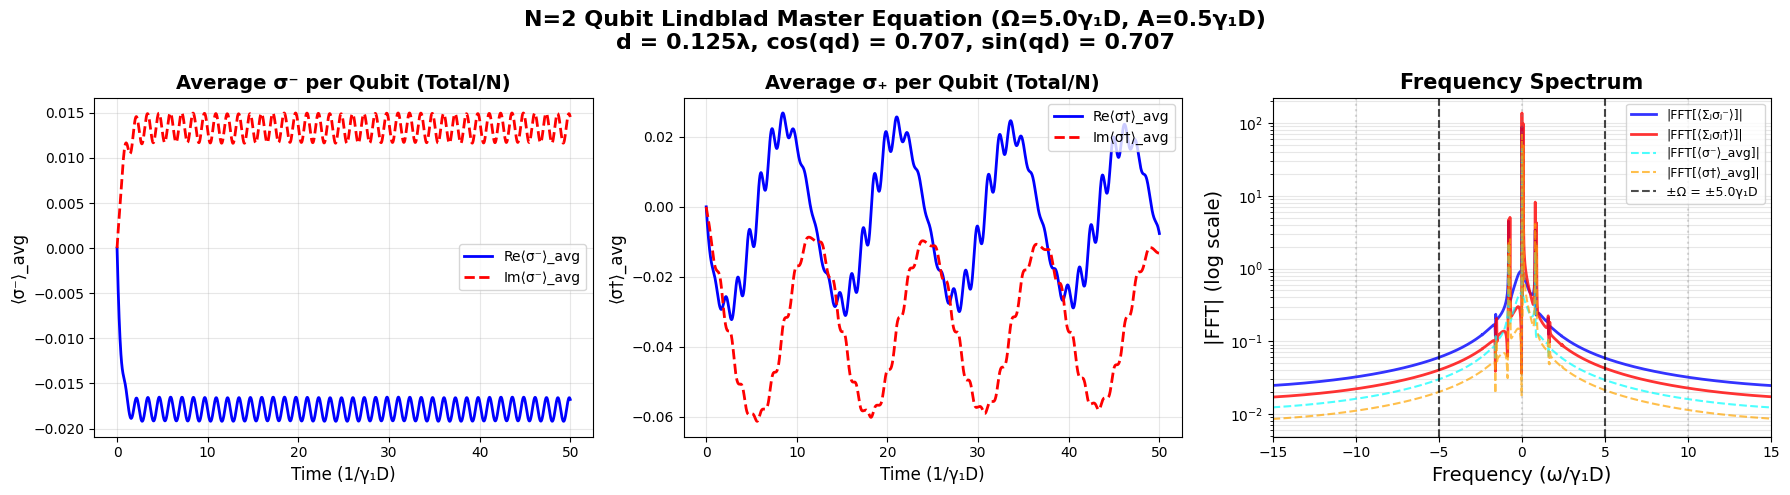

In [47]:
# Run Lindblad simulation
print("Running Lindblad master equation simulation...")
solution, expect_vals = simulate_lindblad(times, psi_ground, N=N, z_positions=z_positions, q=q)
print("Simulation complete!")

fig = plot_lindblad_expectation_values(times, expect_vals, N=N, z_positions=z_positions)
plt.show()